In [ ]:
# Linked-list 형태의 Posting(Inverted Index/Document)

FILE(각 문서)                                   | V(Controled Vocabulary)

In [1]:
from konlpy.corpus import kobill
from konlpy.tag import Kkma

In [18]:
# Inverted index의 장점 -> 수정이 쉽다.
from collections import defaultdict

Documents = list()

kkma = Kkma()
Lexicon = list()

t2i = lambda t:Lexicon.index(t)
i2t = lambda t:Lexicon[t]

d2i = lambda t:Documents.index(t)
i2d = lambda t:Documents[t]

Dicts = defaultdict(lambda: -1)
Postings = list()

for document in [kobill.open(_).read()
                 for _ in kobill.fileids()]:
    Documents.append(document)
    docID = d2i(document)
    for term in [_ for _ in kkma.morphs(document)
              if 1 < len(_) < 6]:
        if term not in Lexicon:
            Lexicon.append(term)
            
        ptr = Dicts[term] # 포인터 = next
        termID = t2i(term)
        postingPtr= len(Postings)
        Postings.append((termID, docID, 1, ptr))
        Dicts[term] = postingPtr

In [19]:
len(Lexicon), len(Documents), Dicts["국민"]

(1139, 10, 6438)

In [28]:
Postings[Dicts[i2t(0)]]

(0, 8, 1, 6660)

In [20]:
ptr = Dicts[i2t(0)]
while ptr != -1:
    _struct = Postings[ptr]
    print(i2t(_struct[0]), _struct[1], _struct[-1])
    ptr = _struct[-1]

지방 8 6660
지방 7 3627
지방 3 3233
지방 3 3197
지방 3 3124
지방 3 3121
지방 3 2734
지방 2 2340
지방 2 2304
지방 2 2231
지방 2 2228
지방 2 1695
지방 1 1301
지방 1 1265
지방 1 1192
지방 1 1189
지방 1 812
지방 0 418
지방 0 382
지방 0 309
지방 0 306
지방 0 279
지방 0 78
지방 0 73
지방 0 0
지방 0 -1


In [21]:
Query = "법안 의원"
Result = list()
for q in [_ for _ in kkma.morphs(Query)
         if 1 < len(_) < 6]:
    candidates = list()
    ptr = Dicts[q]
    while ptr != -1:
        _struct = Postings[ptr]
        candidates.append(_struct[1])
        ptr = _struct[-1]
    Result.append(candidates)

---

# Boolean model
- 문서 내에 query가 있냐 없냐로만 검색함.
- 논리 연산자에 따라서 query 검색결과를 조합한다.
    - AND: 교집합
    - OR: 합집합
    - NOT: 차집합
- 단점: 
    - query가 너무 특이해서 검색결과가 없는 경우
    - query가 너무 흔해서 검색결과가 너무 많은 경우
    - 사용자가 query를 잘 써야함.(일반인에게 난이도가 높을 수 있음)
    - 문서 중에 어느게 더 중요한지 순위를 매길 수 없음.
- 전문적으로 해야하는 검색에서 사용함 
    - 예) 법령 검색, 헌법 검색, 유사특허검색, 도서관 사서 등
    
- 한계:
    - 사용자의 needs에 따라서 query는 다른 중요성을 갖는다.
    - 모든 문서는 동등하게 중요할 수 없다. 
        => 중요성은 정도의 문제이므로 0과 1로 구분할 수 없다. 

# Ranking model
- Relevance
    - Similarity
        \* 가장 사랑받는 녀석!
        - Bag of Words 를 쓸 수 있다.(벡터로 표현 가능)
    - Probability of Relevance
        - Bag of Words를 쓸 수 없다(모든 문서는 동등하지 않다고 가정함.)
    - Probabilistic inferenced
        - Bag of Words를 쓸 수 없다(모든 문서는 동등하지 않다고 가정함.)

# TF (Term Frequency)
    - 단어에 가중치를 매긴다.
    - zipf's law에 기반한다.

# IDF (Inverse Document Frequency)
    - TF와 같이 쓴다. 
    - 빈도가 너무 많거나, 너무 적으면 가중치를 낮게 준다. => 중간 단어가 가중치가 높다.
    - zipf's law에 기반한다.

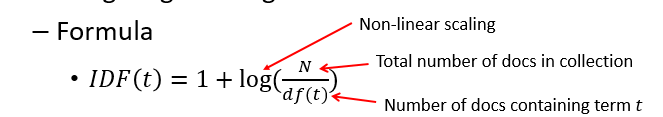

In [83]:
Documents = list()

kkma = Kkma()
Lexicon = list()

t2i = lambda t:Lexicon.index(t)
i2t = lambda t:Lexicon[t]

d2i = lambda t:Documents.index(t)
i2d = lambda t:Documents[t]

Dicts = defaultdict(lambda: -1)
Postings = list()

for docName in kobill.fileids():
    document = kobill.open(docName).read()
    Documents.append(docName)
    docID = d2i(docName)
    localPostings = defaultdict(int)
    for term in [_ for _ in kkma.morphs(document)
              if 1 < len(_) < 6]:
        if term not in Lexicon:
            Lexicon.append(term)
        localPostings[term] += 1
            
    for term, freq in localPostings.items():
        ptr = Dicts[term] # 포인터 = next
        termID = t2i(term)
        postingPtr= len(Postings)
        Postings.append((termID, docID, freq, ptr))
        Dicts[term] = postingPtr

In [84]:
Documents, d2i('1809896.txt')

(['1809890.txt',
  '1809891.txt',
  '1809892.txt',
  '1809893.txt',
  '1809894.txt',
  '1809895.txt',
  '1809896.txt',
  '1809897.txt',
  '1809898.txt',
  '1809899.txt'],
 6)

In [85]:
# 왜 선생님과 값이 다를까?

Dicts["행정"], Postings[2390]

(2390, (236, 9, 2, 1343))

In [86]:
# TF(Term-Frequency)
from math import log

tf1 = lambda t: 1
tf2 = lambda _struct: _struct[1]
tf3 = lambda t:0
tf4 = lambda _struct, t: log(1 + _struct[1])
tf6 = lambda tf, maxtf, a:a+(1-a)*(tf/maxtf)
tf5 = lambda tf, maxtf: tf6(tf, maxtf, 0.5)

In [87]:
_Collections = [
    ["A", "A", "A",  "A", "A"],
    ["A", "A", "A",  "A", "B"],
    ["A", "A", "A",  "A", "C"],
]

_Vocabulary = ["A", "B", "C"]
_Lexicon = defaultdict(lambda: -1)
_Document = defaultdict(int)
_Posting = list()

for d in _Collections:
    _localPosting = defaultdict(int)
    for t in d:
        if t not in _Vocabulary:
            _Vocabulary.append(t)
        _localPosting[t] += 1
    docID = len(_Document)
    _Document[docID] = max(_localPosting.values())
    for t, f in _localPosting.items():
        ptr = _Lexicon[t]
        nextPtr = len(_Posting)
        _Posting.append((docID, f, ptr))
        _Lexicon[t] = nextPtr

In [88]:
_Lexicon, _Document, _Vocabulary

(defaultdict(<function __main__.<lambda>()>, {'A': 3, 'B': 2, 'C': 4}),
 defaultdict(int, {0: 5, 1: 4, 2: 4}),
 ['A', 'B', 'C'])

In [89]:
for t, ptr in _Lexicon.items():
    while ptr != -1:
        _struct = _Posting[ptr]
        print("단어:{0}, 문서:{1}, 빈도:{2}, 최고빈도:{3}"
              .format(
                  t, _struct[0], _struct[1],
                  _Document[_struct[0]]))
        ptr = _struct[-1]

단어:A, 문서:2, 빈도:4, 최고빈도:4
단어:A, 문서:1, 빈도:4, 최고빈도:4
단어:A, 문서:0, 빈도:5, 최고빈도:5
단어:B, 문서:1, 빈도:1, 최고빈도:4
단어:C, 문서:2, 빈도:1, 최고빈도:4


In [90]:
for t, ptr in _Lexicon.items():
    while ptr != -1:
        _struct = _Posting[ptr]
        tf = _struct[1]
        maxtf = _Document[_struct[0]]
        print("단어:{0}, 문서:{1}, 빈도:{2}, 최고빈도:{3}"
              .format(
                  t, _struct[0], _struct[1],
                  _Document[_struct[0]]))
        print("TF1={}".format(tf1(t)))
        print("TF2={}".format(tf2(_struct)))
        print("TF4={}".format(tf4(_struct, t)))
        print("TF5={}".format(tf5(tf, maxtf)))
        print("TF6={}".format(tf6(tf, maxtf, 0)))
        print()
        ptr = _struct[-1]

단어:A, 문서:2, 빈도:4, 최고빈도:4
TF1=1
TF2=4
TF4=1.6094379124341003
TF5=1.0
TF6=1.0

단어:A, 문서:1, 빈도:4, 최고빈도:4
TF1=1
TF2=4
TF4=1.6094379124341003
TF5=1.0
TF6=1.0

단어:A, 문서:0, 빈도:5, 최고빈도:5
TF1=1
TF2=5
TF4=1.791759469228055
TF5=1.0
TF6=1.0

단어:B, 문서:1, 빈도:1, 최고빈도:4
TF1=1
TF2=1
TF4=0.6931471805599453
TF5=0.625
TF6=0.25

단어:C, 문서:2, 빈도:1, 최고빈도:4
TF1=1
TF2=1
TF4=0.6931471805599453
TF5=0.625
TF6=0.25



In [91]:
idf1 = lambda df, N:log(N/df)
idf2 = lambda df, N:log(N/(1+df))
idf3 = lambda df, N:log((1 + N-df)/df)

In [96]:
N = len(_Collections)

for t, ptr in _Lexicon.items():
    dfPtr = ptr
    df = 0
    while dfPtr != -1:
        _struct = _Posting[dfPtr]
        dfPtr = _struct[-1]
        df += 1
    while ptr != -1:
        _struct = _Posting[ptr]
        tf = _struct[1]
        print("단어:{0}, 문서:{1}, 빈도:{2}, 최고빈도:{3}"
              .format(
                  t, _struct[0], _struct[1],
                  maxtf))
        print("TF1={}".format(tf1(t)))
        print("TF2={}".format(tf2(_struct)))
        print("TF4={}".format(tf4(_struct, t)))
        print("TF5={}".format(tf5(tf, maxtf)))
        print("TF6={}".format(tf6(tf, maxtf, 0)))
        print("IDF1={}".format(idf1(df, N)))
        print("IDF2={}".format(idf2(df, N)))
        print("IDF3={}".format(idf3(df, N)))
        print(tf6(tf, maxtf, 0)*idf1(df, N))
        print(tf5(tf, maxtf)*idf1(df, N))
        
        print()
        ptr = _struct[-1]

단어:A, 문서:2, 빈도:4, 최고빈도:4
TF1=1
TF2=4
TF4=1.6094379124341003
TF5=1.0
TF6=1.0
IDF1=0.0
IDF2=-0.2876820724517809
IDF3=-1.0986122886681098
0.0
0.0

단어:A, 문서:1, 빈도:4, 최고빈도:4
TF1=1
TF2=4
TF4=1.6094379124341003
TF5=1.0
TF6=1.0
IDF1=0.0
IDF2=-0.2876820724517809
IDF3=-1.0986122886681098
0.0
0.0

단어:A, 문서:0, 빈도:5, 최고빈도:4
TF1=1
TF2=5
TF4=1.791759469228055
TF5=1.125
TF6=1.25
IDF1=0.0
IDF2=-0.2876820724517809
IDF3=-1.0986122886681098
0.0
0.0

단어:B, 문서:1, 빈도:1, 최고빈도:4
TF1=1
TF2=1
TF4=0.6931471805599453
TF5=0.625
TF6=0.25
IDF1=1.0986122886681098
IDF2=0.4054651081081644
IDF3=1.0986122886681098
0.27465307216702745
0.6866326804175686

단어:C, 문서:2, 빈도:1, 최고빈도:4
TF1=1
TF2=1
TF4=0.6931471805599453
TF5=0.625
TF6=0.25
IDF1=1.0986122886681098
IDF2=0.4054651081081644
IDF3=1.0986122886681098
0.27465307216702745
0.6866326804175686

